In [36]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import grangercausalitytests
from vortexasdk import CargoTimeSeries, Products, Geographies

warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams.update({'font.size': 14})
pd.options.display.max_columns = None

In [37]:
#Defining date range for historical analysis
START_DATE = datetime(2023, 1, 1)
END_DATE = datetime(2024, 3, 31)
DATE_RANGE = pd.date_range(START_DATE, END_DATE)
#Floating storage unit (t = metric tonnes, b = barrels)
UNIT = 't'

In [38]:
def fetch_global_crude_floating_storage_timeseries(start_date, end_date, unit='t'):
    
    # Find Crude/Condensates ID, ensuring its uniqueness
    crude_and_condensates = [p.id for p in Products().search('crude').to_list() if p.name=='Crude/Condensates']
    assert len(crude_and_condensates) == 1
    
    # make Vortexa API query
    # NB: disable_geographic_exclusion_rules is set to True to include intra-movements
    df_fs = CargoTimeSeries().search(timeseries_frequency='day',
                                     timeseries_unit=unit,
                                     intra_movements='all',
                                     filter_products=crude_and_condensates,
                                     filter_activity="storing_state",
                                     filter_time_min=start_date,
                                     filter_time_max=end_date).to_df()

    # rename columns
    df_fs = df_fs.rename(columns={'key': 'date',
                                  'value': unit,
                                  'count': 'number_of_cargo_movements'})
    
    # remove time zone from timestamp
    df_fs['date'] = pd.to_datetime(df_fs['date']).dt.tz_localize(None)
    
    return df_fs

In [39]:
df_fs = fetch_global_crude_floating_storage_timeseries(START_DATE, END_DATE, UNIT)
df_fs

,date,number_of_cargo_movements,t
0,2023-01-01,153,13120500
1,2023-01-02,141,12791481
2,2023-01-03,150,13578099
3,2023-01-04,145,13165243
4,2023-01-05,151,14042673
...,...,...,...
451,2024-03-27,141,10305536
452,2024-03-28,128,10547016
453,2024-03-29,130,10837666
454,2024-03-30,142,11829608


Text(0, 0.5, 'Floating Storage (t)')

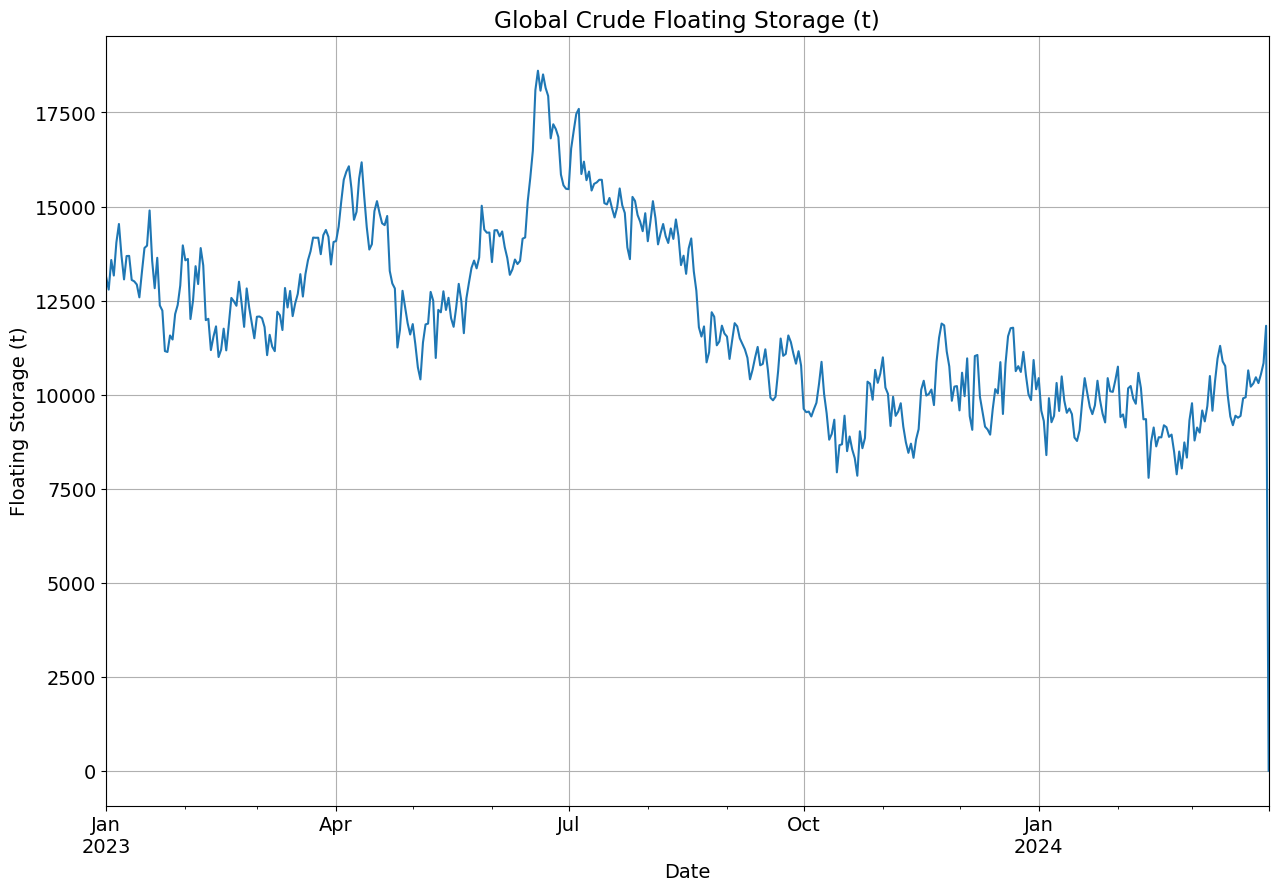

In [40]:
floating_storage = df_fs.set_index('date')[UNIT] / 1000
floating_storage.plot(title='Global Crude Floating Storage (t)', grid=True)
plt.xlabel('Date')
plt.ylabel('Floating Storage (t)')

In [41]:
spot_prices = pd.read_excel('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_D.xls', sheet_name='Data 1', skiprows=[0,1])
spot_prices = spot_prices.set_index('Date').fillna(method='ffill').reindex(DATE_RANGE, method='ffill')
spot_prices

,"Cushing, OK WTI Spot Price FOB (Dollars per Barrel)",Europe Brent Spot Price FOB (Dollars per Barrel)
2023-01-01,80.16,82.82
2023-01-02,80.16,82.82
2023-01-03,76.87,80.36
2023-01-04,72.82,75.31
2023-01-05,73.61,76.73
...,...,...
2024-03-27,82.15,84.94
2024-03-28,83.96,86.17
2024-03-29,83.96,86.17
2024-03-30,83.96,86.17


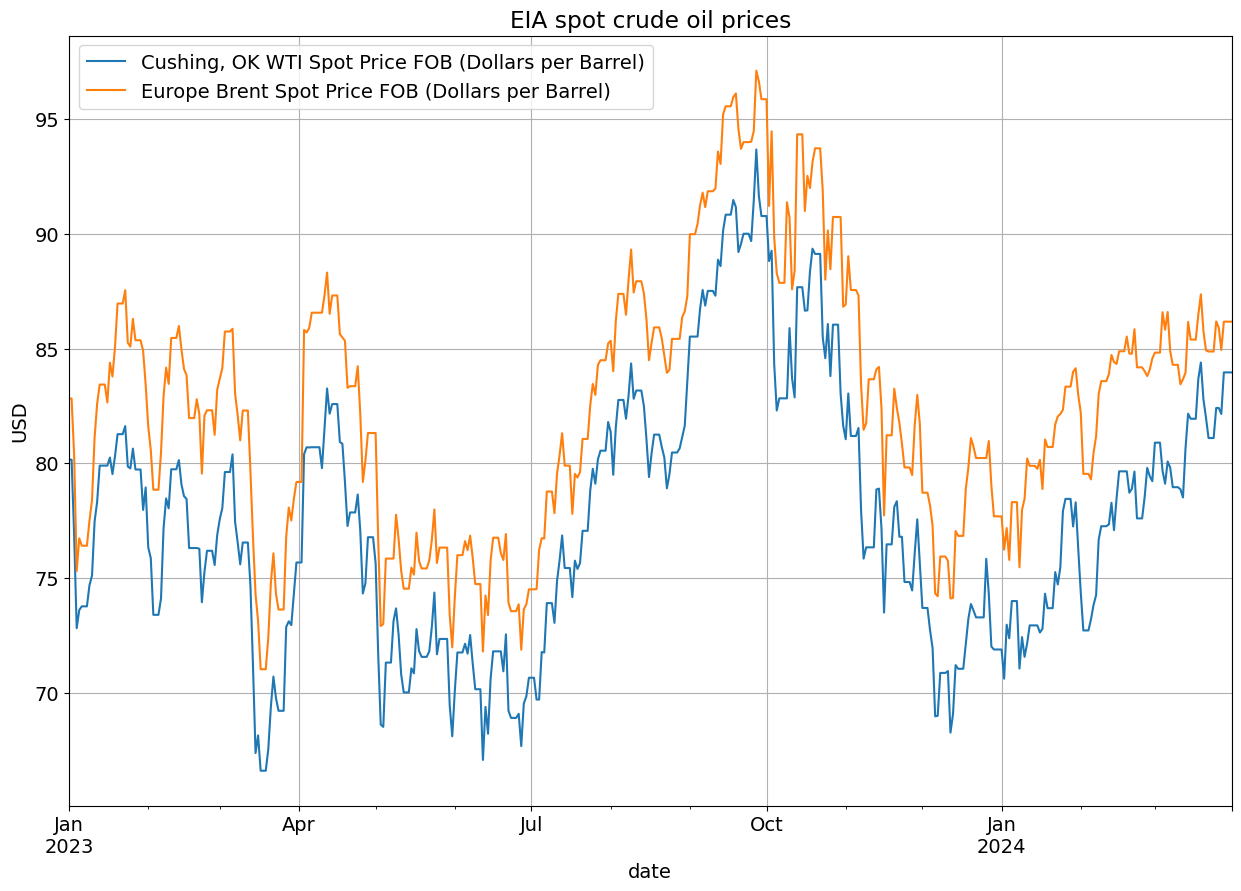

In [42]:
spot_prices.plot(title='EIA spot crude oil prices', grid=True)
plt.xlabel('date')
plt.ylabel('USD');
#remove dates where crude oil prices are nrgative


In [43]:
spot_prices = spot_prices.iloc[:, 0]

In [44]:
future_prices = pd.read_excel('https://www.eia.gov/dnav/pet/xls/PET_PRI_FUT_S1_D.xls', sheet_name='Data 1', skiprows=[0,1])
future_prices = future_prices.set_index('Date').fillna(method='ffill').reindex(DATE_RANGE, method='ffill')
future_prices

,"Cushing, OK Crude Oil Future Contract 1 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 2 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 3 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 4 (Dollars per Barrel)"
2023-01-01,80.26,80.45,80.53,80.45
2023-01-02,80.26,80.45,80.53,80.45
2023-01-03,76.93,77.12,77.27,77.33
2023-01-04,72.84,73.10,73.33,73.51
2023-01-05,73.67,73.92,74.14,74.30
...,...,...,...,...
2024-03-27,81.35,80.78,80.19,79.52
2024-03-28,83.17,82.42,81.67,80.89
2024-03-29,83.17,82.42,81.67,80.89
2024-03-30,83.17,82.42,81.67,80.89


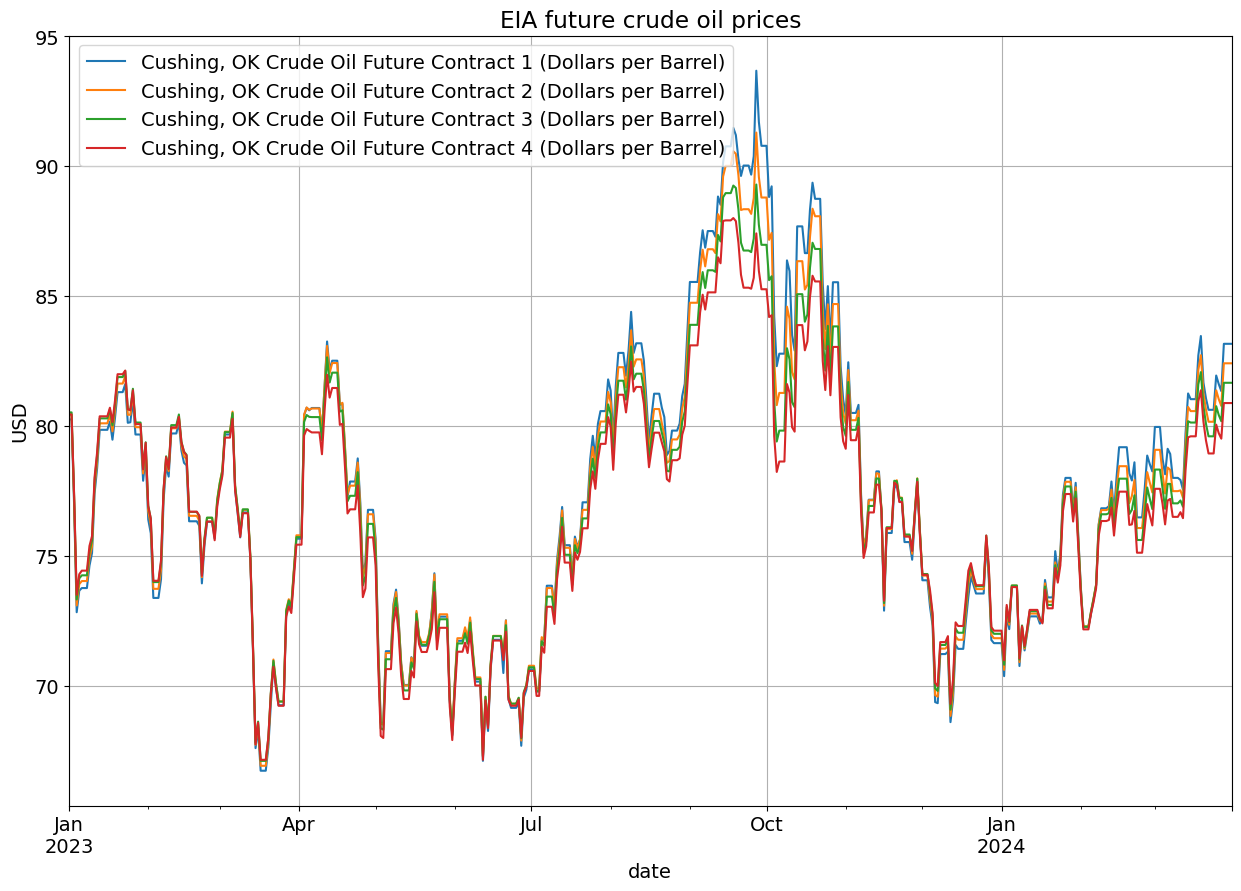

In [45]:
future_prices.plot(title='EIA future crude oil prices', grid=True)
plt.xlabel('date')
plt.ylabel('USD');

In [46]:
calendar_spread = future_prices - pd.concat([spot_prices] * 4, axis=1).values
calendar_spread

,"Cushing, OK Crude Oil Future Contract 1 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 2 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 3 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 4 (Dollars per Barrel)"
2023-01-01,0.10,0.29,0.37,0.29
2023-01-02,0.10,0.29,0.37,0.29
2023-01-03,0.06,0.25,0.40,0.46
2023-01-04,0.02,0.28,0.51,0.69
2023-01-05,0.06,0.31,0.53,0.69
...,...,...,...,...
2024-03-27,-0.80,-1.37,-1.96,-2.63
2024-03-28,-0.79,-1.54,-2.29,-3.07
2024-03-29,-0.79,-1.54,-2.29,-3.07
2024-03-30,-0.79,-1.54,-2.29,-3.07


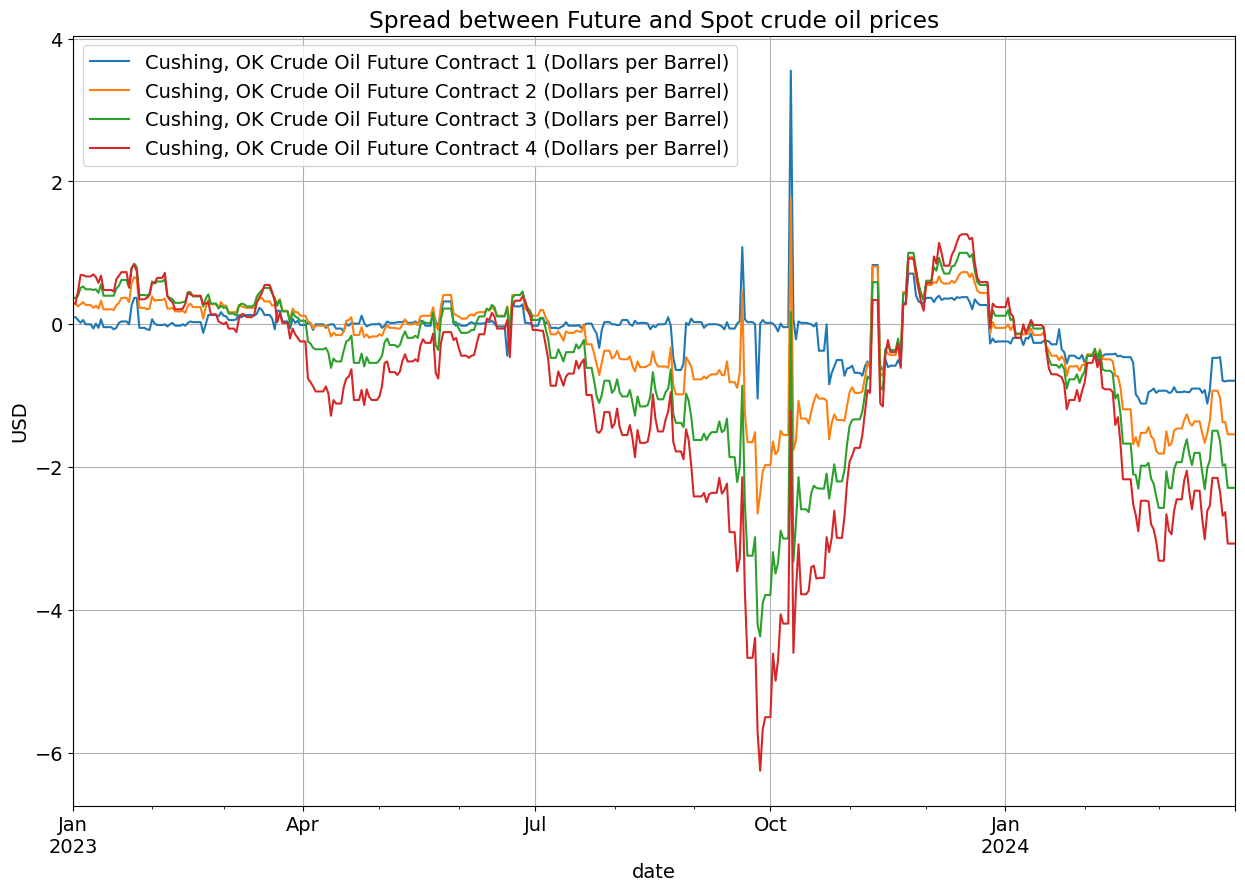

In [47]:
calendar_spread.plot(title='Spread between Future and Spot crude oil prices', grid=True)
plt.xlabel('date')
plt.ylabel('USD');

In [48]:
future_prices = future_prices.iloc[:, 3]
calendar_spread = calendar_spread.iloc[:, 3]

In [49]:
# Maximum lag in days used for cross-correlation and Granger causality analysis
MAXLAG = 100

In [50]:
def crosscorr(series_x, series_y, lags):
    return pd.Series([series_y.corr(series_x.shift(lag)) for lag in lags], index=lags)

In [51]:
crosscorr(calendar_spread, floating_storage, lags=[0, 1])

0    0.345439
1    0.351398
dtype: float64

In [52]:
def plot_crosscorr(series_x, series_y, maxlag, label_x, label_y):
    lags = np.arange(0, maxlag+1)

    plt.subplot(211)
    xcorr_x_y = crosscorr(series_x, series_y, lags)
    xcorr_x_y.plot(title=f'{label_x} -> {label_y}', grid=True)
    plt.ylabel('correlation coeff.')

    plt.subplot(212)
    xcorr_y_x = crosscorr(series_y, series_x, lags)
    xcorr_y_x.plot(title=f'{label_y} -> {label_x}', grid=True)
    plt.xlabel('lag [days]')
    plt.ylabel('correlation coeff.')

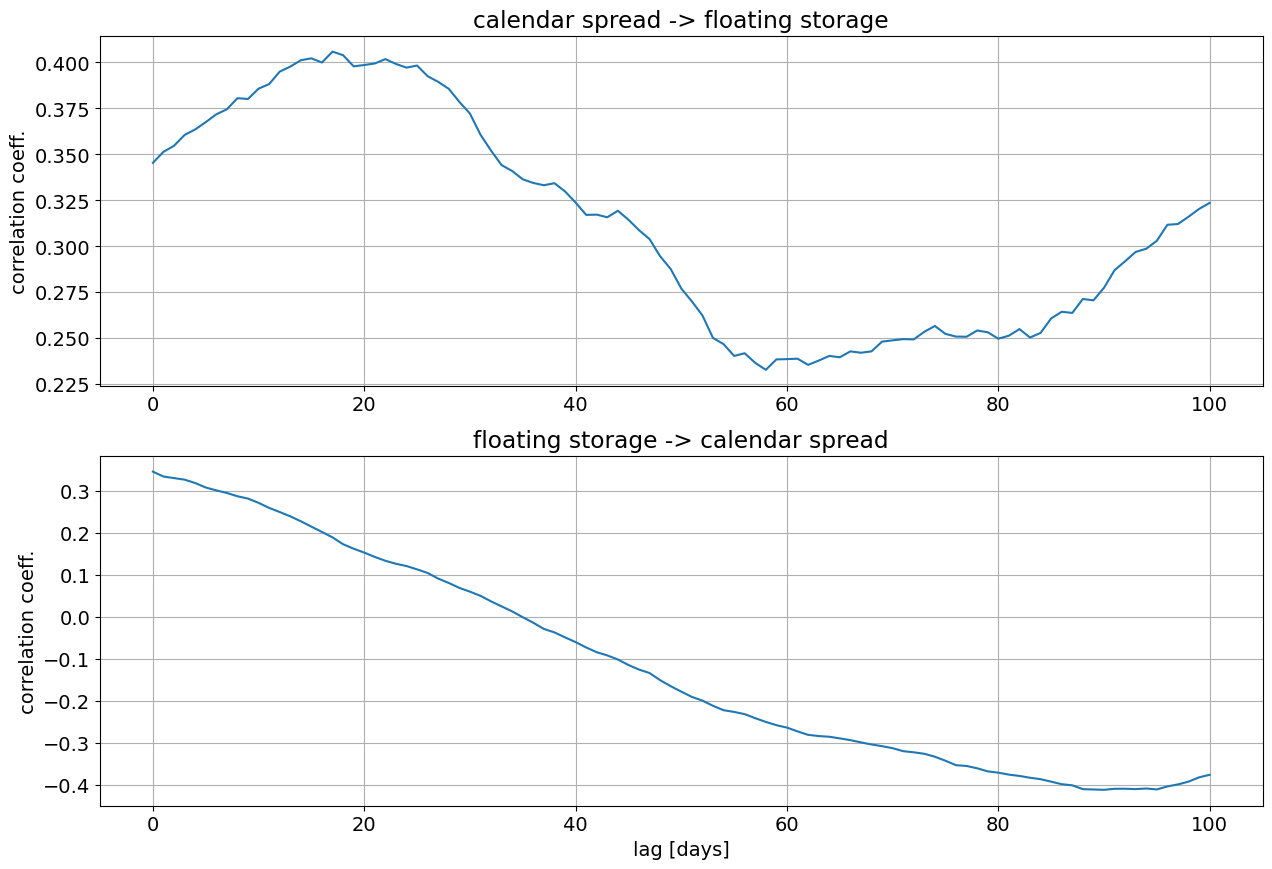

In [53]:
plot_crosscorr(calendar_spread, floating_storage, maxlag=MAXLAG, label_x='calendar spread', label_y='floating storage')

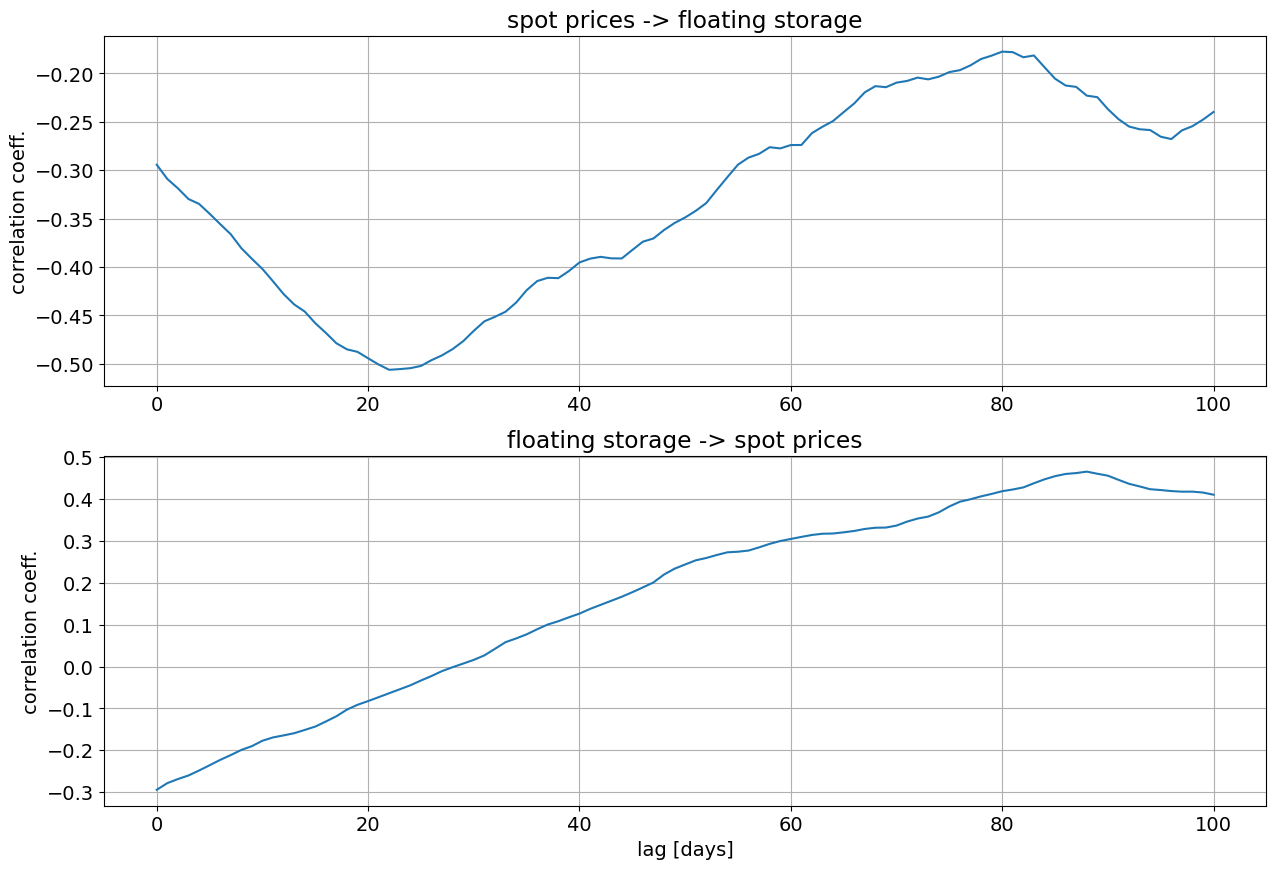

In [54]:
plot_crosscorr(spot_prices, floating_storage, maxlag=MAXLAG, label_x='spot prices', label_y='floating storage')

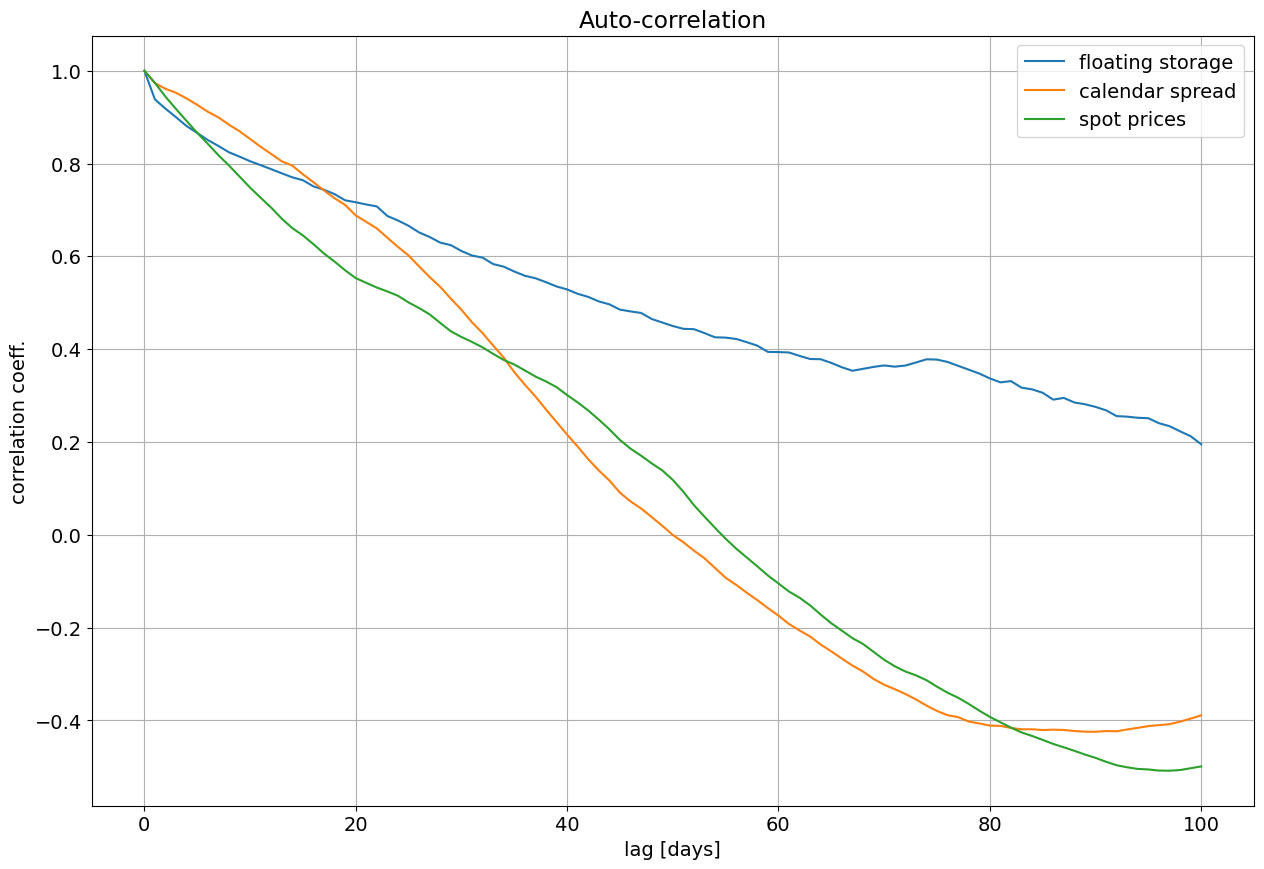

In [55]:
lags = np.arange(0, MAXLAG+1)

crosscorr(floating_storage, floating_storage, lags).plot()
crosscorr(calendar_spread, calendar_spread, lags).plot()
crosscorr(spot_prices, spot_prices, lags).plot()
plt.grid()
plt.title('Auto-correlation')
plt.legend(['floating storage', 'calendar spread', 'spot prices'])
plt.xlabel('lag [days]')
plt.ylabel('correlation coeff.');

In [56]:
gct = grangercausalitytests(pd.concat([floating_storage, calendar_spread], axis=1), maxlag=2, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6633  , p=0.0313  , df_denom=452, df_num=1
ssr based chi2 test:   chi2=4.6942  , p=0.0303  , df=1
likelihood ratio test: chi2=4.6702  , p=0.0307  , df=1
parameter F test:         F=4.6633  , p=0.0313  , df_denom=452, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.2665  , p=0.1049  , df_denom=449, df_num=2
ssr based chi2 test:   chi2=4.5834  , p=0.1011  , df=2
likelihood ratio test: chi2=4.5604  , p=0.1023  , df=2
parameter F test:         F=2.2665  , p=0.1049  , df_denom=449, df_num=2


In [57]:
def plot_granger_pvalues(series_x, series_y, maxlag, label_x, label_y, test='ssr_ftest', confidence_level=0.05):
    lags = np.arange(1, maxlag+1)

    plt.subplot(211)
    gct_x_y = grangercausalitytests(pd.concat([series_y, series_x], axis=1), maxlag=maxlag, verbose=False)
    pvalue_x_y = pd.Series([gct_x_y[lag][0][test][1] for lag in lags], index=lags)
    pvalue_x_y.plot(title=f'{label_x} -> {label_y}', grid=True)
    plt.plot((0, maxlag),(confidence_level, confidence_level),'--r')
    plt.ylabel('p-value')

    plt.subplot(212)
    gct_y_x = grangercausalitytests(pd.concat([series_x, series_y], axis=1), maxlag=maxlag, verbose=False)
    pvalue_y_x = pd.Series([gct_y_x[lag][0][test][1] for lag in lags], index=lags)
    pvalue_y_x.plot(title=f'{label_y} -> {label_x}', grid=True)
    plt.plot((0, maxlag),(confidence_level, confidence_level),'--r')
    plt.xlabel('lag [days]')
    plt.ylabel('p-value')


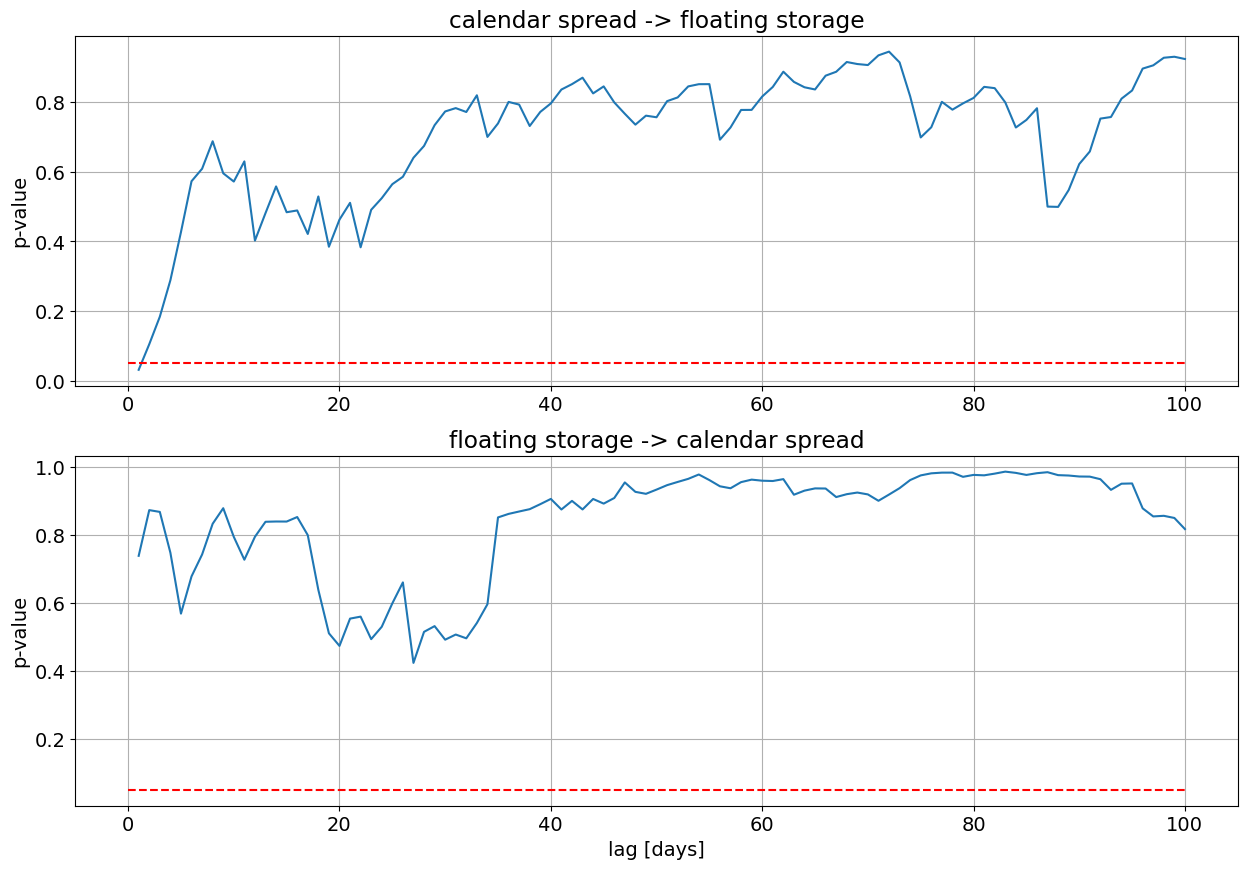

In [58]:
plot_granger_pvalues(calendar_spread, floating_storage, maxlag=MAXLAG, label_x='calendar spread', label_y='floating storage')

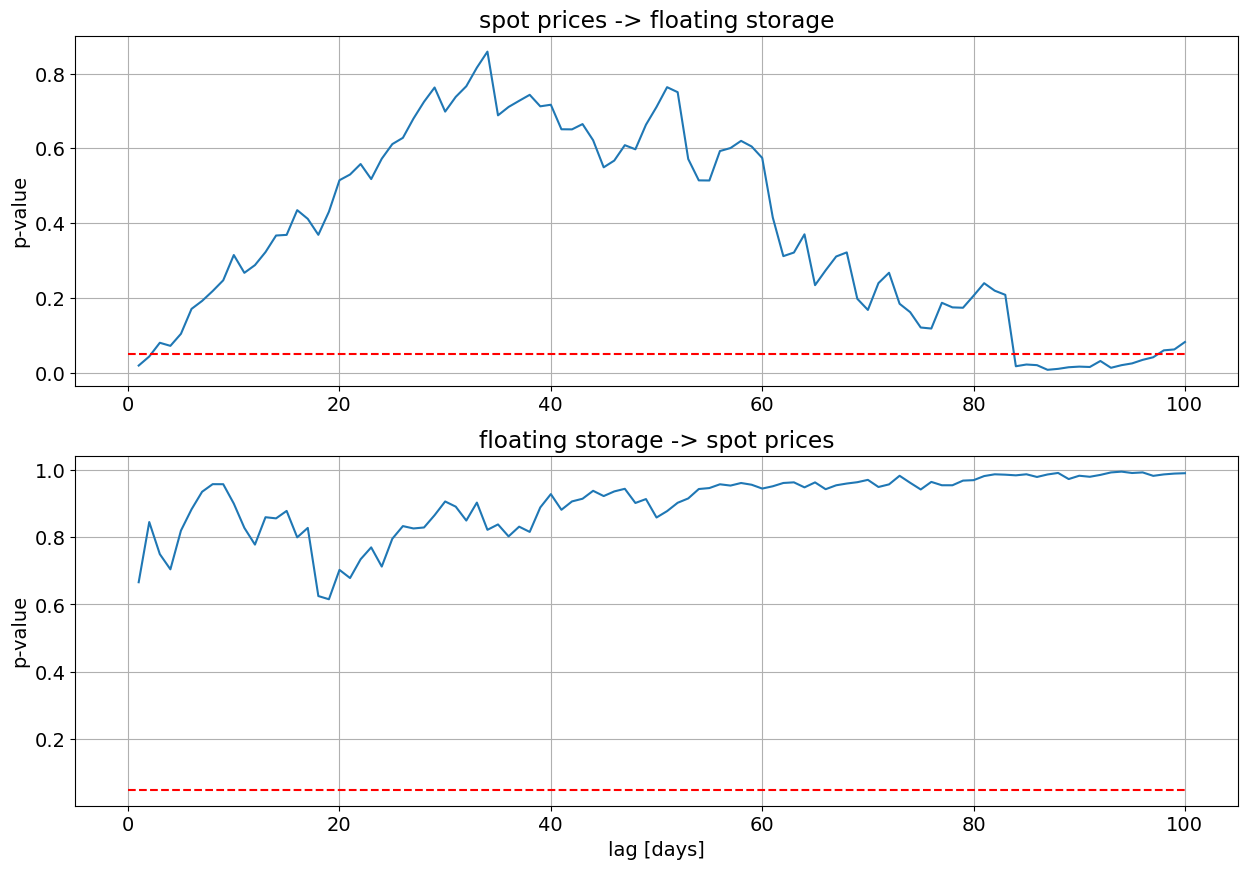

In [59]:
plot_granger_pvalues(spot_prices, floating_storage, maxlag=MAXLAG, label_x='spot prices', label_y='floating storage')

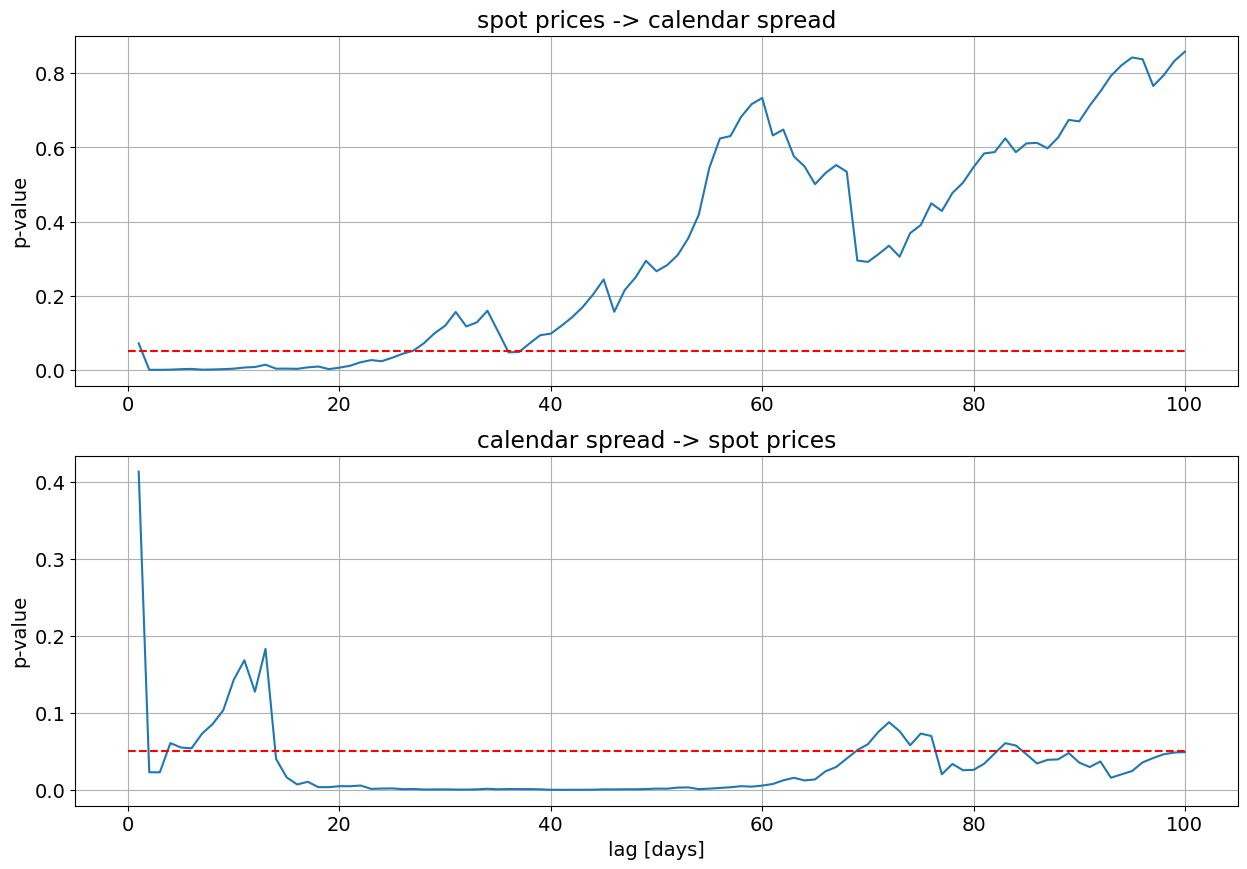

In [60]:
plot_granger_pvalues(spot_prices, calendar_spread, maxlag=MAXLAG, label_x='spot prices', label_y='calendar spread')